In [ ]:
from SimuSamp.functions.load.SpatDat import SpatDat
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from shapely.wkt import loads

In [ ]:
# parent_filepath = "C:/Users/Michael/Desktop/block_data"
parent_filepath = "../../../../Simulated WS Sampling/block_data"

sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

font_dict = {"fontsize": 12, "fontweight": "bold", "fontname": "Arial"}

### Calculate HPFs for all samples

In [3]:
hpfs_600 = []
hpfs_1000 = []
hpfs_2000 = []
for sampleid in sampleids:
    spatdat = SpatDat(sampleid=sampleid, parent_filepath=parent_filepath)
    
    # Compute 0.6mm fields
    spatdat.compute_fields(width_microns=600)
    hpfs_600.append(spatdat.hpfs)

    # Compute 1.0mm fields
    spatdat.compute_fields(width_microns=1000)
    hpfs_1000.append(spatdat.hpfs)

    # Compute 2.0mm fields
    spatdat.compute_fields(width_microns=2000)
    hpfs_2000.append(spatdat.hpfs)

hpfs_600 = pd.concat(hpfs_600).reset_index(drop=True)
hpfs_1000 = pd.concat(hpfs_1000).reset_index(drop=True)
hpfs_2000 = pd.concat(hpfs_2000).reset_index(drop=True)

In [4]:
mean_600 = hpfs_600.groupby(["sampleid", "region"])["density"].transform("mean").reset_index(drop=True)
std_600 = hpfs_600.groupby(["sampleid", "region"])["density"].transform("std").reset_index(drop=True)

mean_1000 = hpfs_1000.groupby(["sampleid", "region"])["density"].transform("mean").reset_index(drop=True)
std_1000 = hpfs_1000.groupby(["sampleid", "region"])["density"].transform("std").reset_index(drop=True)

mean_2000 = hpfs_2000.groupby(["sampleid", "region"])["density"].transform("mean").reset_index(drop=True)
std_2000 = hpfs_2000.groupby(["sampleid", "region"])["density"].transform("std").reset_index(drop=True)

hpfs_600["norm_density"] = (hpfs_600["density"] - mean_600) / std_600

hpfs_1000["norm_density"] = (hpfs_1000["density"] - mean_1000) / std_1000

hpfs_2000["norm_density"] = (hpfs_2000["density"] - mean_2000) / std_2000

In [5]:
hpfs_600.to_excel("../../../../Data/hpfs_600.xlsx", index=False)
hpfs_1000.to_excel("../../../../Data/hpfs_1000.xlsx", index=False)
hpfs_2000.to_excel("../../../../Data/hpfs_2000.xlsx", index=False)

## Sample Size Estimation

In [69]:
hpfs_600 = pd.read_excel("../../../../Data/hpfs_600.xlsx")
hpfs_1000 = pd.read_excel("../../../../Data/hpfs_1000.xlsx")
hpfs_2000 = pd.read_excel("../../../../Data/hpfs_2000.xlsx")

In [4]:
hpf_tum = [loads(x) for x in hpfs_600[(hpfs_600["sampleid"] == "01_F") & (hpfs_600["region"] == "tumour")]["geometry"]]
hpf_tum = gpd.GeoDataFrame(geometry=hpf_tum)

hpf_im = [loads(x) for x in hpfs_600[(hpfs_600["sampleid"] == "01_F") & (hpfs_600["region"] == "IM")]["geometry"]]
hpf_im = gpd.GeoDataFrame(geometry=hpf_im)

In [ ]:
# hpf_tum = [loads(x) for x in hpfs_1000[(hpfs_1000["sampleid"] == "01_F") & (hpfs_1000["region"] == "tumour")]["geometry"]]
# hpf_tum = gpd.GeoDataFrame(geometry=hpf_tum)

# hpf_im = [loads(x) for x in hpfs_1000[(hpfs_1000["sampleid"] == "01_F") & (hpfs_1000["region"] == "IM")]["geometry"]]
# hpf_im = gpd.GeoDataFrame(geometry=hpf_im)

In [ ]:
# hpf_tum = [loads(x) for x in hpfs_2000[(hpfs_2000["sampleid"] == "01_F") & (hpfs_2000["region"] == "tumour")]["geometry"]]
# hpf_tum = gpd.GeoDataFrame(geometry=hpf_tum)

# hpf_im = [loads(x) for x in hpfs_2000[(hpfs_2000["sampleid"] == "01_F") & (hpfs_2000["region"] == "IM")]["geometry"]]
# hpf_im = gpd.GeoDataFrame(geometry=hpf_im)

In [5]:
spatdat = SpatDat("01_F", parent_filepath)

In [6]:
tum = spatdat.subset_annotation("tumour")
im = spatdat.subset_annotation("outer_IM_hull")

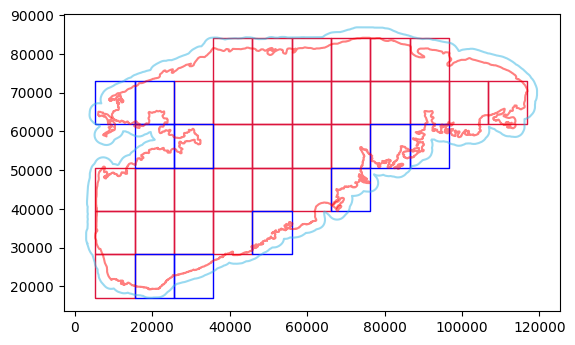

In [42]:
hpf_tum.plot(color="None", edgecolor="crimson")
hpf_im.plot(color="None", edgecolor="blue", ax=plt.gca())
for geom in tum.geoms:
    plt.plot(*geom.exterior.xy, color="red", alpha=0.5)
# for geom in im.geoms:
#     plt.plot(*geom.exterior.xy, color="green")

plt.plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)
    
plt.savefig("../../../../Data/example_hpfs_600.png", dpi=300, transparent=True)

In [70]:
def sample_size_estimator(data_mean, data_std, rel_error=0.2, z=1.96):
    n = (z * data_std / (data_mean * rel_error)) ** 2
    return n

In [71]:
samples = []
regions = []
ns = []
area_per_sample = []
for sampleid in sampleids:
    test_tum = hpfs_600[(hpfs_600["sampleid"] == sampleid) & (hpfs_600["region"] == "tumour")].reset_index(drop=True)

    test_im = hpfs_600[(hpfs_600["sampleid"] == sampleid) & (hpfs_600["region"] == "IM")].reset_index(drop=True)

    # Plot Tumour histogram =========================================
    plt.hist(test_tum["norm_density"], bins=100, color="lightcoral", edgecolor="black")

    plt.xlabel("Stdev from Mean Density", fontdict=font_dict)
    plt.ylabel("Frequency", fontdict=font_dict)

    plt.title(f"{sampleid} Tumour Density Distribution", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/Density/Distributions_600/{sampleid}_tumour_den_distribution.png", dpi=300, transparent=True)

    plt.cla()
    plt.clf()
    # ===============================================================

    # Plot IM histogram =============================================
    plt.hist(test_im["norm_density"], bins=100, color=(52/255, 181/255, 227/255), edgecolor="black", density=True)

    plt.xticks(fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    plt.xlabel("Stdev from Mean Density", fontdict=font_dict)
    plt.ylabel("Frequency", fontdict=font_dict)

    plt.title(f"{sampleid} Tumour Density Distribution", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/Density/Distributions_600/{sampleid}_IM_den_distribution.png", dpi=300, transparent=True)

    plt.cla()
    plt.clf()
    # ===============================================================

    tum_mean = test_tum["density"].mean()
    tum_std = test_tum["density"].std()

    im_mean = test_im["density"].mean()
    im_std = test_im["density"].std()

    tum_n = sample_size_estimator(tum_mean, tum_std)
    im_n = sample_size_estimator(im_mean, im_std)

    samples.append(sampleid)
    regions.append("tumour")
    ns.append(tum_n)
    area_per_sample.append(0.6 ** 2)
    samples.append(sampleid)
    regions.append("IM")
    ns.append(im_n)
    area_per_sample.append(0.6 ** 2)

samples_600 = pd.DataFrame({"sampleid": samples, "region": regions, "samples": ns, "area_per_sample": area_per_sample})

<Figure size 640x480 with 0 Axes>

In [72]:
samples = []
regions = []
ns = []
area_per_sample = []
for sampleid in sampleids:
    test_tum = hpfs_1000[(hpfs_1000["sampleid"] == sampleid) & (hpfs_1000["region"] == "tumour")].reset_index(drop=True)

    test_im = hpfs_1000[(hpfs_1000["sampleid"] == sampleid) & (hpfs_1000["region"] == "IM")].reset_index(drop=True)

    tum_mean = test_tum["density"].mean()
    tum_std = test_tum["density"].std()

    im_mean = test_im["density"].mean()
    im_std = test_im["density"].std()

    if any(test_tum["norm_density"].isna()):
        pass
    else:
        # Plot Tumour histogram =======================================
        plt.hist(test_tum["norm_density"], bins=100, color="lightcoral", edgecolor="black")

        plt.xlabel("Stdev from Mean Density", fontdict=font_dict)
        plt.ylabel("Frequency", fontdict=font_dict)

        plt.title(f"{sampleid} Tumour Density Distribution", fontdict=font_dict)

        plt.savefig(f"../../../../Data/Plots/Density/Distributions_1000/{sampleid}_tumour_den_distribution.png", dpi=300, transparent=True)

        plt.cla()
        plt.clf()
        # =============================================================

    if any(test_im["norm_density"].isna()):
        pass
    else:
        # Plot IM histogram =============================================
        plt.hist(test_im["norm_density"], bins=100, color=(52/255, 181/255, 227/255), edgecolor="black", density=True)

        plt.xticks(fontsize=10, fontname="Arial")
        plt.yticks(fontsize=10, fontname="Arial")

        plt.xlabel("Stdev from Mean Density", fontdict=font_dict)
        plt.ylabel("Frequency", fontdict=font_dict)

        plt.title(f"{sampleid} Tumour Density Distribution", fontdict=font_dict)

        plt.savefig(f"../../../../Data/Plots/Density/Distributions_1000/{sampleid}_IM_den_distribution.png", dpi=300, transparent=True)

        plt.cla()
        plt.clf()
        # =============================================================
    
    
    tum_n = sample_size_estimator(tum_mean, tum_std)
    im_n = sample_size_estimator(im_mean, im_std)

    samples.append(sampleid)
    regions.append("tumour")
    ns.append(tum_n)
    area_per_sample.append(1.0 ** 2)
    samples.append(sampleid)
    regions.append("IM")
    ns.append(im_n)
    area_per_sample.append(1.0 ** 2)

samples_1000 = pd.DataFrame({"sampleid": samples, "region": regions, "samples": ns, "area_per_sample": area_per_sample})

<Figure size 640x480 with 0 Axes>

In [73]:
samples = []
regions = []
ns = []
area_per_sample = []
for sampleid in sampleids:
    test_tum = hpfs_2000[(hpfs_2000["sampleid"] == sampleid) & (hpfs_2000["region"] == "tumour")].reset_index(drop=True)

    test_im = hpfs_2000[(hpfs_2000["sampleid"] == sampleid) & (hpfs_2000["region"] == "IM")].reset_index(drop=True)

    if any(test_tum["norm_density"].isna()):
        pass
    else:
        # Plot Tumour histogram =======================================
        plt.hist(test_tum["norm_density"], bins=100, color="lightcoral", edgecolor="black")

        plt.xlabel("Stdev from Mean Density", fontdict=font_dict)
        plt.ylabel("Frequency", fontdict=font_dict)

        plt.title(f"{sampleid} Tumour Density Distribution", fontdict=font_dict)

        plt.savefig(f"../../../../Data/Plots/Density/Distributions_2000/{sampleid}_tumour_den_distribution.png", dpi=300, transparent=True)

        plt.cla()
        plt.clf()
        # =============================================================

    if any(test_im["norm_density"].isna()):
        pass
    else:
        # Plot IM histogram ===========================================
        plt.hist(test_im["norm_density"], bins=100, color=(52/255, 181/255, 227/255), edgecolor="black", density=True)

        plt.xticks(fontsize=10, fontname="Arial")
        plt.yticks(fontsize=10, fontname="Arial")

        plt.xlabel("Stdev from Mean Density", fontdict=font_dict)
        plt.ylabel("Frequency", fontdict=font_dict)

        plt.title(f"{sampleid} Tumour Density Distribution", fontdict=font_dict)

        plt.savefig(f"../../../../Data/Plots/Density/Distributions_2000/{sampleid}_IM_den_distribution.png", dpi=300, transparent=True)

        plt.cla()
        plt.clf()
        # =============================================================

    tum_mean = test_tum["density"].mean()
    tum_std = test_tum["density"].std()

    im_mean = test_im["density"].mean()
    im_std = test_im["density"].std()

    tum_n = sample_size_estimator(tum_mean, tum_std)
    im_n = sample_size_estimator(im_mean, im_std)

    samples.append(sampleid)
    regions.append("tumour")
    ns.append(tum_n)
    area_per_sample.append(2.0 ** 2)
    samples.append(sampleid)
    regions.append("IM")
    ns.append(im_n)
    area_per_sample.append(2.0 ** 2)

samples_2000 = pd.DataFrame({"sampleid": samples, "region": regions, "samples": ns, "area_per_sample": area_per_sample})

<Figure size 640x480 with 0 Axes>

In [12]:
samples_total = pd.concat([samples_600, samples_1000, samples_2000]).reset_index(drop=True)

In [13]:
samples_total.to_excel("../../../../Data/hpfs_total.xlsx", index=False)

In [14]:
samples_total = pd.read_excel("../../../../Data/hpfs_total.xlsx")

In [15]:
ws = pd.read_excel("../../../../Data/WS_stats.xlsx")
ws = ws.rename(columns={"sample": "sampleid", "annotation": "region", "density": "ws_density", "area_mm": "ws_area"})

In [16]:
samples_total = samples_total.merge(ws[["sampleid", "region", "ws_density", "ws_area"]], on=["sampleid", "region"], how="left")

In [17]:
samples_total["rel_area_sampled"] = samples_total["samples"] * samples_total["area_per_sample"] / samples_total["ws_area"]

In [18]:
samples_total["rel_area_sampled_adj"] = [min(1.0, x) for x in samples_total["rel_area_sampled"]]

In [19]:
samples_total_test = samples_total.dropna(subset="samples").reset_index(drop=True)

In [20]:
samples_total_test.groupby(["region", "area_per_sample"])[["rel_area_sampled_adj", "samples"]].mean().reset_index()

,region,area_per_sample,rel_area_sampled_adj,samples
0,IM,0.36,0.313749,60.300419
1,IM,1.00,0.530056,42.246946
2,IM,4.00,0.731146,24.113030
3,tumour,0.36,0.348180,53.148737
4,tumour,1.00,0.459317,37.193560
5,tumour,4.00,0.524989,18.264243


In [22]:
samples_total.groupby(["region", "area_per_sample"])["rel_area_sampled"].mean().reset_index()

,region,area_per_sample,rel_area_sampled
0,IM,0.36,0.340391
1,IM,1.00,0.647320
2,IM,4.00,1.360778
3,tumour,0.36,0.380132
4,tumour,1.00,0.605109
5,tumour,4.00,0.807750


## Cumulative Distribution, IM vs CT Distributions

In [28]:
for sampleid in sampleids:
    data = hpfs_600[(hpfs_600["region"] == "tumour") & (hpfs_600["sampleid"] == sampleid)].reset_index(drop=True)

    data = data.sort_values("density", ascending=False).reset_index(drop=True)
    data["cum_count"] = data["cell_count"].cumsum()
    data["cum_area"] = data["area"].cumsum()
    data["area_prop"] = data["cum_area"] / data["area"].sum()

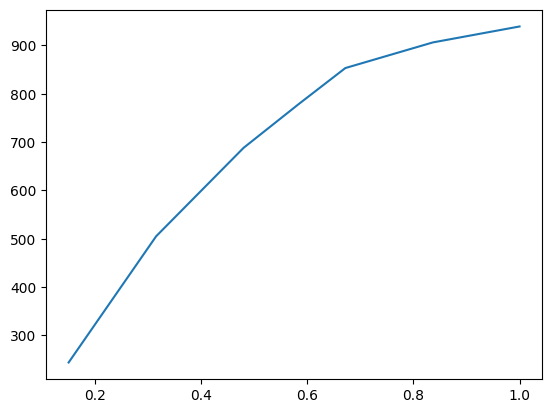

In [29]:
plt.plot(data["area_prop"], data["cum_count"])

(array([0.00324247, 0.        , 0.        , 0.00648494, 0.00324247,
        0.        , 0.02269727, 0.03566714, 0.02918221, 0.06809182,
        0.03566714, 0.05187948, 0.10375897, 0.10700143, 0.23021521,
        0.15239598, 0.35342898, 0.2204878 , 0.27885222, 0.5123099 ,
        0.45070301, 0.34370158, 0.9338307 , 0.48637016, 0.40855093,
        0.41503587, 0.39233859, 0.35667145, 0.40855093, 0.37288379,
        0.37288379, 0.30479196, 0.3015495 , 0.32424677, 0.28209469,
        0.24967001, 0.24642755, 0.24318508, 0.16212339, 0.2107604 ,
        0.15239598, 0.14266858, 0.13942611, 0.11672884, 0.13618364,
        0.09727403, 0.07781922, 0.07781922, 0.07133429, 0.08754663,
        0.05836442, 0.04215208, 0.03566714, 0.03566714, 0.02593974,
        0.03566714, 0.03566714, 0.02593974, 0.02593974, 0.01296987,
        0.02269727, 0.01296987, 0.01945481, 0.00648494, 0.0097274 ,
        0.        , 0.00324247, 0.00648494, 0.00324247, 0.00648494,
        0.00324247, 0.        , 0.00324247, 0.  

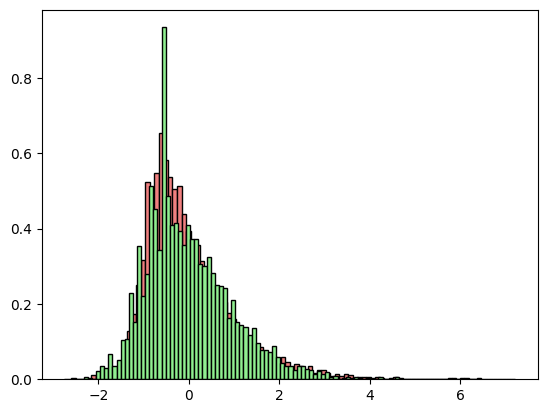

In [30]:
data = hpfs_600.copy()

plt.hist(data[data["region"] == "tumour"]["norm_density"], bins=100, color="lightcoral", label="0.6mm", edgecolor="black", density=True)
plt.hist(data[data["region"] == "IM"]["norm_density"], bins=100, color="lightgreen", label="0.6mm", edgecolor="black", density=True)

In [31]:
new_df = hpfs_600.groupby(["sampleid", "region"])["density"].mean().reset_index()
new_df["std_den"] = hpfs_600.groupby(["sampleid", "region"])["density"].std().reset_index()["density"]

In [32]:
new_df["sample_area"] = ((1.96*new_df["std_den"])/(0.1*new_df["density"]))**2 * 0.6**2

In [33]:
new_df = new_df.merge(hpfs_600.groupby(["sampleid", "region"])["area"].sum().reset_index(), on=["sampleid", "region"], how="left")

In [34]:
new_df["sample_prop"] = (new_df["sample_area"] / new_df["area"]).clip(upper=1)

In [35]:
new_df["sample_prop_mod"] = new_df["sample_prop"] / (1 + new_df["sample_prop"]/1.0)

In [36]:
new_df

,sampleid,region,density,std_den,sample_area,area,sample_prop,sample_prop_mod
0,01_F,IM,857.022514,521.752479,51.257713,27.714240,1.000000,0.500000
1,01_F,tumour,812.195255,382.617348,30.691850,190.696899,0.160946,0.138633
2,01_G,IM,209.880244,274.937581,237.322951,17.434275,1.000000,0.500000
3,01_G,tumour,251.073662,200.062538,87.809980,25.969811,1.000000,0.500000
4,02_G,IM,909.544439,478.556946,38.285476,18.864705,1.000000,0.500000
...,...,...,...,...,...,...,...,...
65,28_FSC,tumour,130.919018,95.776747,74.016634,55.651452,1.000000,0.500000
66,29_L,IM,393.749116,286.071362,73.000230,46.989374,1.000000,0.500000
67,29_L,tumour,151.195041,106.742601,68.931085,27.993684,1.000000,0.500000
68,30_D,IM,709.571904,593.258416,96.673989,27.415380,1.000000,0.500000


In [37]:
new_df[new_df["region"] == "tumour"]["sample_prop_mod"].mean()

0.411463943903919

In [38]:
new_df[new_df["region"] == "IM"]["sample_prop_mod"].mean()

0.48148934541145494

### Calculate Mean Density in Top and Bottom Tertile per Sampleid

In [ ]:
sampleid_list = []
min_list = []
max_list = []
for sampleid in sampleids:
    spatdat = SpatDat(sampleid=sampleid, parent_filepath=parent_filepath)
    spatdat.compute_fields(width_microns=300)

    hpfs = spatdat.hpfs.sort_values("density").reset_index(drop=True)
    min_hpf = hpfs.iloc[:len(hpfs) // 3]["density"].mean()
    max_hpf = hpfs.iloc[-len(hpfs) // 3:]["density"].mean()

    sampleid_list.append(sampleid)
    min_list.append(min_hpf)
    max_list.append(max_hpf)

results = pd.DataFrame({"sampleid": sampleid_list, "mean_bottom": min_list, "mean_top": max_list})
results

,sampleid,mean_bottom,mean_top
0,01_F,311.249739,1392.295520
1,01_G,3.396343,582.168411
2,02_G,397.736308,1731.960410
3,02_H,170.019900,747.408057
4,03_B,0.000000,444.468845
5,03_H,27.254009,587.565365
6,04_I,106.598958,823.814780
7,04_N,100.662989,913.185303
8,05_G,171.682277,1564.396521
9,05_I,93.253766,1735.786383


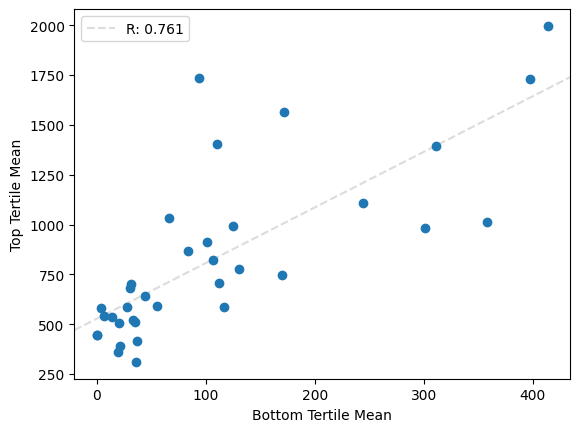

In [22]:
plt.scatter(results["mean_bottom"], results["mean_top"])
plt.xlabel("Bottom Tertile Mean")
plt.ylabel("Top Tertile Mean")

slope, intercept, r_value, p_value, std_err = stats.linregress(results["mean_bottom"], results["mean_top"])

plt.gca().axline((0, intercept), slope=slope, color="gainsboro", linestyle="--", zorder=0, label=f"R: {round(r_value, 3)}")
plt.gca().legend()
